
\begin{center}
Chun-Yuan (Scott) Chiu
\end{center}
\begin{center}
chunyuac@andrew.cmu.edu
\end{center}

# 1. {-}

In [2]:
import yfinance as yf
import numpy as np
import datetime

kd = yf.download('K', start=datetime.date(1973, 12, 31), end=datetime.date(2019, 12, 31)).reset_index()
kd.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,1973-12-31,0.0,1.953125,1.937500,1.937500,0.393612,36000
1,1974-01-02,0.0,1.937500,1.890625,1.890625,0.384089,27200
2,1974-01-03,0.0,2.000000,1.890625,2.000000,0.406309,220800
3,1974-01-04,0.0,2.000000,1.968750,1.968750,0.399961,39200
4,1974-01-07,0.0,1.984375,1.953125,1.953125,0.396786,54400


In [3]:
kd['month'] = [date.month for date in kd['Date']]
kd['year'] = [date.year for date in kd['Date']]
kd = kd[['Date', 'year', 'month', 'Adj Close']]
km = kd.groupby(['year', 'month']).last()
ky = kd.groupby(['year']).last()

In [4]:
km.head()

Date  Adj Close
year month                      
1973 12    1973-12-31   0.393612
1974 1     1974-01-31   0.447575
     2     1974-02-28   0.422181
     3     1974-03-29   0.409484
     4     1974-04-30   0.422181

In [5]:
ky.head()

,Date,month,Adj Close
year,,,
1973,1973-12-31,12,0.393612
1974,1974-12-31,12,0.387264
1975,1975-12-31,12,0.545978
1976,1976-12-31,12,0.701518
1977,1977-12-30,12,0.618987


In [47]:
ldr = np.log(kd['Adj Close']).diff()[1:].values
lmr = np.log(km['Adj Close']).diff()[1:].values
lyr = np.log(ky['Adj Close']).diff()[1:].values

len(ldr), len(lmr), len(lyr)

(11602, 552, 46)

/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using silverman for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for 

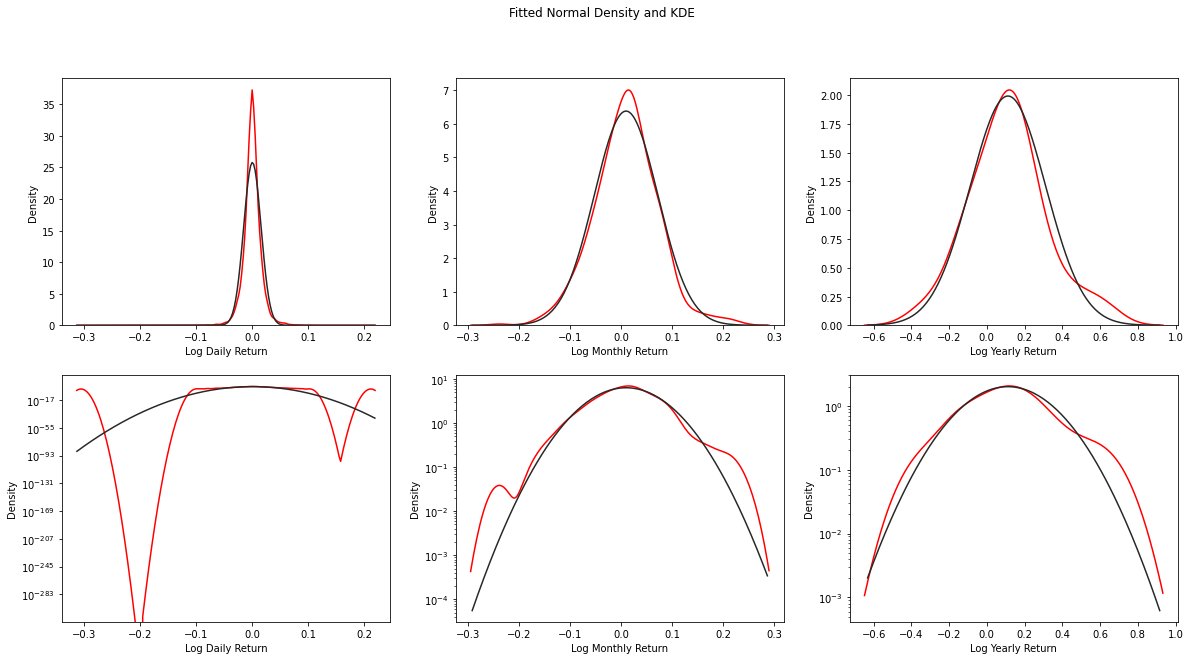

In [33]:
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Fitted Normal Density and KDE')

sns.distplot(ldr, hist=False, kde_kws={'bw': 'silverman'}, color='red', fit=stats.norm, ax=axs[0][0])
sns.distplot(lmr, hist=False, kde_kws={'bw': 'silverman'}, color='red', fit=stats.norm, ax=axs[0][1])
sns.distplot(lyr, hist=False, kde_kws={'bw': 'silverman'}, color='red', fit=stats.norm, ax=axs[0][2])

sns.distplot(ldr, hist=False, kde_kws={'bw': 'silverman'}, color='red', fit=stats.norm, ax=axs[1][0])
sns.distplot(lmr, hist=False, kde_kws={'bw': 'silverman'}, color='red', fit=stats.norm, ax=axs[1][1])
sns.distplot(lyr, hist=False, kde_kws={'bw': 'silverman'}, color='red', fit=stats.norm, ax=axs[1][2])

for j in range(3):
    axs[1][j].set(yscale='log')

for i in range(2):
    axs[i][0].set(xlabel='Log Daily Return')
    axs[i][1].set(xlabel='Log Monthly Return')
    axs[i][2].set(xlabel='Log Yearly Return')

plt.show()


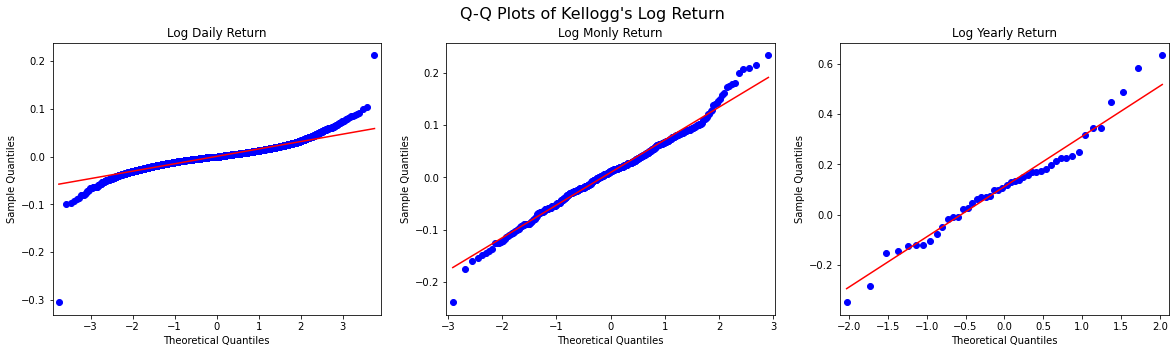

In [46]:
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle("Q-Q Plots of Kellogg's Log Return", fontsize=16)

qqplot(ldr, line='s', ax=axs[0])
qqplot(lmr, line='s', ax=axs[1])
qqplot(lyr, line='s', ax=axs[2])

axs[0].set(title='Log Daily Return')
axs[1].set(title='Log Monly Return')
axs[2].set(title='Log Yearly Return')

plt.show()

# 2. {-}

## Implementation Details {-}

To implement the ```fitSkewT()``` function we will need the log likelihood of the skewed generalized t distribution (SGT) and hence the pdf, which we implement as ```pdf()```. The implementation is straightforward from the original paper by Theodossiou (1998) with $x$ replaced by $x-\mu$ to add a shift to the distribution. To find the MLE we use a numerical optimization procedure, which requires an initial guess for each parameter. For $\mu, \sigma^2, k$ and $n$ we use the same initial guesses as in class, which are sample mean for $\mu$, sample variance for $\sigma^2$, $k=2$, $n=15$. 


To obtain an initial guess of $\lambda$ we make use of a property of SGT: If $X$ follows the SGT (with the shift $\mu=0$) then $P(X > 0) = (1+\lambda)/2$. This property is given by Theorem 2 in Theodossiou (1998). Adding the shift, this property says $P(X+\mu > \mu) = (1+\lambda)/2$, or equivalently $\lambda = 2P(X+\mu > \mu) -1$. Thus we compute the sample probability that the generated random number is greater than the shift, where shift is estimated by the sample mean. The sample probability is then multiplied by 2 and minus 1. The result is used as the initial guess of $\lambda$. 


In ```fitSkewT()``` we also call ```numdifftools.Hessian``` to compute the Hessian matrix of the log likelihood function at the MLE, the inverse of which is the covariance matrix of the MLE and is returned along with the MLE itself. 


To test the accuracy of the computed MLE, the cumulative distribution function and its inverse are also implemented (as ```cdf()``` and ```ppf()```, respectively). The implementation of ```cdf()``` again makes use of the property $P(X+\mu < \mu) = (1-\lambda)/2$, which implies that 
$$
F_{X+\mu}(c) = P(X+\mu < c) = (1-\lambda)/2 + \int_\mu^c f_X(x) dx, 
$$
where $F_{X+\mu}(x)$ is the desired cdf of SGT with drift, and $f_X(x)$ is the pdf of SGT *without* drift. Thus the computation of the cdf at any values of $c$ only involves a definite integral, which is easier and faster to compute numerically, compared to an improper integral. 


To compute ```ppf()``` at a given value $y$ is to find the solution of $F_{X+\mu}(x) - y = 0$, where $F_{X+\mu}(x)$ is given by ```cdf()```. We use Newton's method in ```scipy.optimize.root_scalar```. SGT with drift $\mu$ has a nice property that the peak is always at $\mu$, which means $\mu$ is the inflection point of $F_{X+\mu}(x) - y$. Thus, using $\mu$ as an initial guess, Newton's method is guaranteed to converge. 


Finally a ```rvs()``` function is implemented to generate SGT random numbers given sample size and parameters using the inverse transform sampling, which is straightforward given ```ppf()```. 

In [ ]:
from pandas import DataFrame
from scipy.special import beta
from scipy.optimize import minimize, root_scalar
from scipy.integrate import quad
from scipy import stats
import numpy as np
import numdifftools as nd

def pdf(x, mu, k, n, lam, sigma2, log=False):
    '''
    k > 0, n > 2, sigma2 > 0, -1 < lam < 1
    '''
    sigma = np.sqrt(sigma2)

    S = np.sqrt(1 + 3*(lam**2) - 4*(lam**2)*((beta(2/k, (n-1)/k)**2)/(beta(1/k, n/k)*beta(3/k, (n-2)/k))))
    c = 0.5*k*np.sqrt((beta(1/k, n/k)**(-3))*beta(3/k, (n-2)/k))*S/sigma
    theta = ((k/(n-2))**(1/k))*np.sqrt(beta(1/k, n/k)/beta(3/k, (n-2)/k))/S
    
    if log:
        return np.log(c)-(n+1)*np.log(1 + (k/(n-2))*(np.abs(x-mu)/(sigma*theta*(1 + np.sign(x-mu)*lam)))**k)/k
    else:
        return c*(1+(k/(n-2))*(np.abs(x-mu)/(sigma*theta*(1 + np.sign(x-mu)*lam)))**k)**(-(n+1)/k)

def cdf(x, mu, k, n, lam, sigma2):
    integrand = lambda u: pdf(u-mu, 0, k, n, lam, sigma2)
    return quad(integrand, mu, x)[0] + (1-lam)/2

def ppf(y, mu, k, n, lam, sigma2):
    assert 0 < y < 1, 'y must be in [0, 1].'  
    res = root_scalar(lambda x: cdf(x, mu, k, n, lam, sigma2)-y, method='newton', x0=mu, fprime=lambda x: pdf(x, mu, k, n, lam, sigma2))
    assert res.converged, "Newton's method failed to converge."
    return res.root

def rvs(size, mu, k, n, lam, sigma2):
    return np.array([ppf(u, mu, k, n, lam, sigma2) for u in np.random.uniform(size=size)])

def fitSkewT(x, allowshift=False):
    
    if(allowshift):
        initMu = np.mean(x)
        initpars = [initMu, 2, 15, 2*(np.array(x) > initMu).sum()/len(x)-1, np.var(x)]
        def negloglikelihood(params, x):
            mu, k, n, lam, sigma2 = params
            return (-1)*pdf(x, mu, k, n, lam, sigma2, log=True).sum()
        
        mleout = minimize(negloglikelihood, initpars, args=(x), method='L-BFGS-B', bounds=[(None, None), (0.001, None), (2.001, None), (-0.999, 0.999), (0.001, None)])
        hessfunc = nd.Hessian(negloglikelihood)
        return mleout.x, np.linalg.inv(hessfunc(mleout.x, x))
    
    else:
        initpars = [2, 15, 2*(np.array(x)>0).sum()/len(x)-1, np.var(x)]
        def negloglikelihood(params, x):
            k, n, lam, sigma2 = params
            return (-1)*pdf(x, 0, k, n, lam, sigma2, log=True).sum()
        
        mleout = minimize(negloglikelihood, initpars, args=(x), method='L-BFGS-B', bounds=[(0.001, None), (2.001, None), (-0.999, 0.999), (0.001, None)])
        hessfunc = nd.Hessian(negloglikelihood)
        mat = hessfunc(mleout.x, x)
        return mleout.x, np.linalg.inv(hessfunc(mleout.x, x))

## Test with $\mu=0$ {-}

Below we put everything together to test ```fitSkewT()```. First we run the test without shift, meaning $\mu=0$. 50,000 SGT random numbers are generated with parameters $k=2, n=10, \lambda=-0.5, \sigma^2=1$ and the MLE and its covariance matrix are computed. Despite the warning given by ```numdifftools.Hessian```, the results show that the MLE found is accurate and the true parameters are all covered in the corresponding confidence interval, which confirms that all functions are implemented correctly. 

A thorough debugging shows that the warnings are from ```numdifftools.Hessian```, which computes the 2nd derivative of a function $f$ using the finite difference method: 
\begin{align*}
f^{\prime\prime}(x) \approx \frac{f(x+\Delta x) - 2f(x) + f(x-\Delta x)}{\Delta x^2}. 
\end{align*}
Without careful controls, for example, $x-\Delta x$ may go out of the domain of $f$ when $x$ is close to zero and $f$ involves square root or logarithm which only takes positive numbers. To fix the warning would require to change the code in ```numdifftools.Hessian``` to take the extreme cases into consideration. 

In [4]:
size = 50000
k = 2
n = 10
lam = -0.5
sigma2 = 1
mu = 0

x = rvs(size, mu, k, n, lam, sigma2)

mle, var = fitSkewT(x, allowshift=False)
z = stats.norm.ppf(1-0.025)

print('MLE for k, n, lambda and sigma2: ', mle)
print()
print('Covariance matrix of the MLE: \n', DataFrame(var, columns=['k', 'n', 'lambda', 'sigma2'], index=['k', 'n', 'lambda', 'sigma2']))
print()
print('Confidence Intervals for the 4 parameters: ', [(mle[i] - z*np.sqrt(var[i][i]), mle[i] + z*np.sqrt(var[i][i])) for i in range(4)])

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in power
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt

MLE for k, n, lambda and sigma2:  [ 2.00279629  9.18781764 -0.49442739  1.00352337]

Covariance matrix of the MLE: 
                k         n    lambda    sigma2
k       0.002139 -0.029235 -0.000002  0.000015
n      -0.029235  0.517771  0.000035 -0.001835
lambda -0.000002  0.000035  0.000006 -0.000003
sigma2  0.000015 -0.001835 -0.000003  0.000078

Confidence Intervals for the 4 parameters:  [(1.9121427083818585, 2.0934498809955633), (7.777500203504956, 10.598135080701034), (-0.49923916883011465, -0.4896156039852224), (0.986254867355361, 1.0207918723970564)]


## Test with Nonzero Shift

Next we run the same test but with a nonzero shift $\mu=1.5$. 50,000 SGT random numbers are generated with the same parameters as above and the MLE and its covariance matrix are computed. Again, despite the warning given by ```numdifftools.Hessian```, the results show that the MLE found is accurate, indicating that the implementation with nonzero shift is correct. 

In [5]:
size = 50000
k = 2
n = 10
lam = -0.5
sigma2 = 1
mu = 1.5

x = rvs(size, mu, k, n, lam, sigma2)

mle, var = fitSkewT(x, allowshift=True)
z = stats.norm.ppf(1-0.025)

print('MLE for mu, k, n, lambda and sigma2: ', mle)
print()
print('Covariance matrix of the MLE: \n', DataFrame(var, columns=['mu', 'k', 'n', 'lambda', 'sigma2'], index=['mu', 'k', 'n', 'lambda', 'sigma2']))
print()
print('Confidence Intervals for the 5 parameters: ', [(mle[i] - z*np.sqrt(var[i][i]), mle[i] + z*np.sqrt(var[i][i])) for i in range(5)])


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in power
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


MLE for mu, k, n, lambda and sigma2:  [ 1.52455894  1.99154301 10.0033813  -0.5161979   1.00705431]

Covariance matrix of the MLE: 
               mu         k         n    lambda    sigma2
mu      0.000064  0.000009 -0.000134 -0.000040  0.000022
k       0.000009  0.002111 -0.034118 -0.000005  0.000004
n      -0.000134 -0.034118  0.713508  0.000073 -0.001866
lambda -0.000040 -0.000005  0.000073  0.000031 -0.000017
sigma2  0.000022  0.000004 -0.001866 -0.000017  0.000082

Confidence Intervals for the 5 parameters:  [(1.5089083422544234, 1.5402095409151402), (1.9014922791252897, 2.081593742225219), (8.347811605534284, 11.658951003649657), (-0.5270349447867958, -0.5053608469149563), (0.9892791548484049, 1.0248294619946112)]
